In [1]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import numpy as np
import scipy.stats as stats
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error
from pickle import dump, load
from binance.client import Client

In [2]:
df_1 = yf.download('BTC-USD', start = '2015-01-01', end = '2020-12-31')
df_1 = df_1.drop(['Adj Close'], axis = 1)
df_1

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Volume
Date,,,,,
2014-12-31,310.914001,320.192993,310.210999,320.192993,13942900
2015-01-01,320.434998,320.434998,314.002991,314.248993,8036550
2015-01-02,314.079010,315.838989,313.565002,315.032013,7860650
2015-01-03,314.846008,315.149994,281.082001,281.082001,33054400
2015-01-04,281.145996,287.230011,257.612000,264.195007,55629100
...,...,...,...,...,...
2020-12-26,24677.015625,26718.070312,24522.689453,26437.037109,48332647295
2020-12-27,26439.373047,28288.839844,25922.769531,26272.294922,66479895605
2020-12-28,26280.822266,27389.111328,26207.640625,27084.808594,49056742893


In [3]:
api_key = 'insert api key'
secret_key = 'insert secret key'

In [4]:
client = Client(api_key = api_key, api_secret = secret_key)

In [5]:
# Creating a function to retrieve data based on symbol/pair and desired transactioning interval
# it retrieves all available Binance information 

def get_history(symbol, interval, start = None, end = None):
    
    if start == None:
        start = client._get_earliest_valid_timestamp(symbol=symbol, interval=interval)
    else:
        pass
    bars = client.get_historical_klines(symbol=symbol, interval=interval,
                                       start_str=start, end_str=end, limit = 1000)
    
    df = pd.DataFrame(bars)
    df['Date'] = pd.to_datetime(df.iloc[:,0], unit='ms')
    df.columns = ['Open Time','Open','High','Low','Close','Volume',
                 'Close Time','Quote Asset Volume','Number of Trades',
                 'Taker Buy Base Asset Volume','Taker Buy Quote Asset Volumne',
                 'Ignore','Date']
    
    df = df[['Date','Open','High','Low','Close','Volume']].copy()
    df.set_index('Date', inplace=True)
    
    for column in df.columns:
        df[column] = pd.to_numeric(df[column], errors = 'coerce')
        
    return df

In [6]:
# Example of generated dataframe using previously defined function

df_2 = get_history('BTCUSDT', '1d', start='2020-12-31',end='2022-05-23')
df_2

,Open,High,Low,Close,Volume
Date,,,,,
2020-12-31,28875.55,29300.00,27850.00,28923.63,75508.505152
2021-01-01,28923.63,29600.00,28624.57,29331.69,54182.925011
2021-01-02,29331.70,33300.00,28946.53,32178.33,129993.873362
2021-01-03,32176.45,34778.11,31962.99,33000.05,120957.566750
2021-01-04,33000.05,33600.00,28130.00,31988.71,140899.885690
...,...,...,...,...,...
2022-05-19,28715.33,30545.18,28691.38,30319.23,67877.364150
2022-05-20,30319.22,30777.33,28730.00,29201.01,60517.253250
2022-05-21,29201.01,29656.18,28947.28,29445.06,20987.131240


In [7]:
df = pd.concat([df_1, df_2], axis=0)
df

,Open,High,Low,Close,Volume
Date,,,,,
2014-12-31,310.914001,320.192993,310.210999,320.192993,1.394290e+07
2015-01-01,320.434998,320.434998,314.002991,314.248993,8.036550e+06
2015-01-02,314.079010,315.838989,313.565002,315.032013,7.860650e+06
2015-01-03,314.846008,315.149994,281.082001,281.082001,3.305440e+07
2015-01-04,281.145996,287.230011,257.612000,264.195007,5.562910e+07
...,...,...,...,...,...
2022-05-19,28715.330000,30545.180000,28691.380000,30319.230000,6.787736e+04
2022-05-20,30319.220000,30777.330000,28730.000000,29201.010000,6.051725e+04
2022-05-21,29201.010000,29656.180000,28947.280000,29445.060000,2.098713e+04


In [8]:
df = df.iloc[:-1,:]

In [9]:
df

,Open,High,Low,Close,Volume
Date,,,,,
2014-12-31,310.914001,320.192993,310.210999,320.192993,1.394290e+07
2015-01-01,320.434998,320.434998,314.002991,314.248993,8.036550e+06
2015-01-02,314.079010,315.838989,313.565002,315.032013,7.860650e+06
2015-01-03,314.846008,315.149994,281.082001,281.082001,3.305440e+07
2015-01-04,281.145996,287.230011,257.612000,264.195007,5.562910e+07
...,...,...,...,...,...
2022-05-18,30444.930000,30709.990000,28654.470000,28715.320000,5.974916e+04
2022-05-19,28715.330000,30545.180000,28691.380000,30319.230000,6.787736e+04
2022-05-20,30319.220000,30777.330000,28730.000000,29201.010000,6.051725e+04


In [10]:
test_period = 90 
train_data = pd.DataFrame(df.Close[:len(df) - test_period])
test_data = pd.DataFrame(df.Close[len(df) - test_period:])

In [11]:
first_to_scale = train_data.iloc[0:840,:]
second_to_scale = train_data.iloc[840:2192,:]
third_to_scale = train_data.iloc[2192:,:]

In [12]:
# Scaling separately based on trend

scaler = MinMaxScaler()
scaler.fit(first_to_scale)
train_data.iloc[0:840,:] = scaler.transform(first_to_scale)
scaler.fit(second_to_scale)
train_data.iloc[840:2192,:] = scaler.transform(second_to_scale)
scaler = load(open('scaler.pkl', 'rb'))
train_data.iloc[2192:,:] = scaler.transform(third_to_scale)

In [13]:
test_data = scaler.transform(test_data)

In [14]:
train_data = train_data.values.reshape(-1,1)
train_data

array([[0.12953932],
       [0.12412035],
       [0.12483421],
       ...,
       [0.28898716],
       [0.2451482 ],
       [0.20943185]])

In [15]:
inputs = np.concatenate((train_data, test_data), axis=0)
inputs = inputs[len(inputs) - len(test_data)-12:]

In [16]:
n_past = 12
n_future = 1

x_test = []
for i in range (n_past, len(inputs) - n_future + 1):
    x_test.append(inputs[i-n_past:i])

x_test = np.array(x_test)
print(x_test)

[[[ 0.37748652]
  [ 0.34842833]
  [ 0.34439073]
  ...
  [ 0.28898716]
  [ 0.2451482 ]
  [ 0.20943185]]

 [[ 0.34842833]
  [ 0.34439073]
  [ 0.34013683]
  ...
  [ 0.2451482 ]
  [ 0.20943185]
  [ 0.24109248]]

 [[ 0.34439073]
  [ 0.34013683]
  [ 0.35263042]
  ...
  [ 0.20943185]
  [ 0.24109248]
  [ 0.21569703]]

 ...

 [[ 0.13249944]
  [ 0.02986047]
  [ 0.05423188]
  ...
  [ 0.03940967]
  [-0.00539632]
  [ 0.03615338]]

 [[ 0.02986047]
  [ 0.05423188]
  [ 0.00467098]
  ...
  [-0.00539632]
  [ 0.03615338]
  [ 0.0071856 ]]

 [[ 0.05423188]
  [ 0.00467098]
  [ 0.00274907]
  ...
  [ 0.03615338]
  [ 0.0071856 ]
  [ 0.01350778]]]


In [17]:
model = load_model('bitcoin_model.h5')

In [18]:
predicted_price = model.predict(x_test)

In [19]:
predicted_price_usd = scaler.inverse_transform(predicted_price)

In [20]:
true = scaler.inverse_transform(test_data)

In [21]:
predictions = []
true_values = []

for i in range(len(true)):
    predictions.append(predicted_price_usd[i].item())
    true_values.append(true[i].item())

In [22]:
diff = pd.DataFrame({'true': true_values, 'pred':predictions})
diff

,true,pred
0,38230.33,37279.695312
1,37250.01,38163.890625
2,38327.21,37386.726562
3,39219.17,38295.632812
4,39116.72,39175.121094
...,...,...
85,28715.32,30514.140625
86,30319.23,28988.019531
87,29201.01,30146.677734
88,29445.06,29319.033203


In [23]:
diff['true_lag1'] = diff.true.shift(periods=1)

In [24]:
diff["position"] = 0
diff.loc[diff.pred > diff.true_lag1*1.003, 'position'] = 1
diff.loc[diff.pred < diff.true_lag1*0.997, 'position'] = -1

In [28]:
diff.position.value_counts()

 0    41
 1    35
-1    13
Name: position, dtype: int64

In [25]:
diff["returns"] = np.log(diff.true.div(diff.true.shift(1)))

In [26]:
diff = diff[1:]

In [36]:
diff["creturns"] = diff.returns.cumsum().apply(np.exp)

<ipython-input-36-ce2b6a739a2e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diff["creturns"] = diff.returns.cumsum().apply(np.exp)


In [37]:
diff

,true,pred,true_lag1,position,returns,prof_loss,creturns
1,37250.01,38163.890625,38230.33,0,-0.025977,-0.00,0.974358
2,38327.21,37386.726562,37250.01,1,0.028508,1077.20,1.002534
3,39219.17,38295.632812,38327.21,0,0.023006,0.00,1.025865
4,39116.72,39175.121094,39219.17,0,-0.002616,-0.00,1.023186
5,37699.07,39216.300781,39116.72,0,-0.036915,-0.00,0.986104
...,...,...,...,...,...,...,...
85,28715.32,30514.140625,30444.93,0,-0.058489,-0.00,0.751114
86,30319.23,28988.019531,28715.32,1,0.054351,1603.91,0.793067
87,29201.01,30146.677734,30319.23,-1,-0.037579,1118.22,0.763818
88,29445.06,29319.033203,29201.01,1,0.008323,244.05,0.770202


In [40]:
diff['strategy'] = diff.returns*diff.position
diff["cstrategy"] = diff["strategy"].cumsum().apply(np.exp) 

<ipython-input-40-5970f8f273e8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diff['strategy'] = diff.returns*diff.position
<ipython-input-40-5970f8f273e8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diff["cstrategy"] = diff["strategy"].cumsum().apply(np.exp)


In [41]:
diff

,true,pred,true_lag1,position,returns,prof_loss,creturns,strategy,cstrategy
1,37250.01,38163.890625,38230.33,0,-0.025977,-0.00,0.974358,-0.000000,1.000000
2,38327.21,37386.726562,37250.01,1,0.028508,1077.20,1.002534,0.028508,1.028918
3,39219.17,38295.632812,38327.21,0,0.023006,0.00,1.025865,0.000000,1.028918
4,39116.72,39175.121094,39219.17,0,-0.002616,-0.00,1.023186,-0.000000,1.028918
5,37699.07,39216.300781,39116.72,0,-0.036915,-0.00,0.986104,-0.000000,1.028918
...,...,...,...,...,...,...,...,...,...
85,28715.32,30514.140625,30444.93,0,-0.058489,-0.00,0.751114,-0.000000,1.230320
86,30319.23,28988.019531,28715.32,1,0.054351,1603.91,0.793067,0.054351,1.299041
87,29201.01,30146.677734,30319.23,-1,-0.037579,1118.22,0.763818,0.037579,1.348786
88,29445.06,29319.033203,29201.01,1,0.008323,244.05,0.770202,0.008323,1.360059


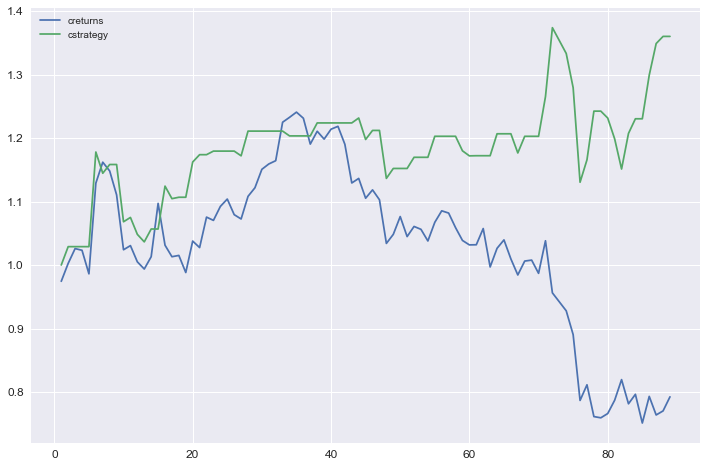

In [42]:
diff[["creturns", "cstrategy"]].plot(figsize = (12 , 8), fontsize = 12)
plt.show()

In [45]:
diff["trades"] = diff.position.diff().fillna(0).abs()

<ipython-input-45-b4bee250069a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diff["trades"] = diff.position.diff().fillna(0).abs()


In [47]:
commissions = 0.001
other = 0.0001 # proportional costs for bid-ask spread & slippage
ptc = np.log(1 - commissions) + np.log(1 - other)
ptc

-0.0011005053339168817

In [48]:
diff["strategy_net"] = diff.strategy + diff.trades * ptc 

<ipython-input-48-cc9f32183dfb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diff["strategy_net"] = diff.strategy + diff.trades * ptc


In [50]:
diff["cstrategy_net"] = diff.strategy_net.cumsum().apply(np.exp)

<ipython-input-50-fa8f9450d9b6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diff["cstrategy_net"] = diff.strategy_net.cumsum().apply(np.exp)


In [51]:
diff

,true,pred,true_lag1,position,returns,prof_loss,creturns,strategy,cstrategy,trades,strategy_net,cstrategy_net
1,37250.01,38163.890625,38230.33,0,-0.025977,-0.00,0.974358,-0.000000,1.000000,0.0,-0.000000,1.000000
2,38327.21,37386.726562,37250.01,1,0.028508,1077.20,1.002534,0.028508,1.028918,1.0,0.027407,1.027786
3,39219.17,38295.632812,38327.21,0,0.023006,0.00,1.025865,0.000000,1.028918,1.0,-0.001101,1.026656
4,39116.72,39175.121094,39219.17,0,-0.002616,-0.00,1.023186,-0.000000,1.028918,0.0,-0.000000,1.026656
5,37699.07,39216.300781,39116.72,0,-0.036915,-0.00,0.986104,-0.000000,1.028918,0.0,-0.000000,1.026656
...,...,...,...,...,...,...,...,...,...,...,...,...
85,28715.32,30514.140625,30444.93,0,-0.058489,-0.00,0.751114,-0.000000,1.230320,1.0,-0.001101,1.164451
86,30319.23,28988.019531,28715.32,1,0.054351,1603.91,0.793067,0.054351,1.299041,1.0,0.053251,1.228139
87,29201.01,30146.677734,30319.23,-1,-0.037579,1118.22,0.763818,0.037579,1.348786,2.0,0.035378,1.272366
88,29445.06,29319.033203,29201.01,1,0.008323,244.05,0.770202,0.008323,1.360059,2.0,0.006122,1.280179


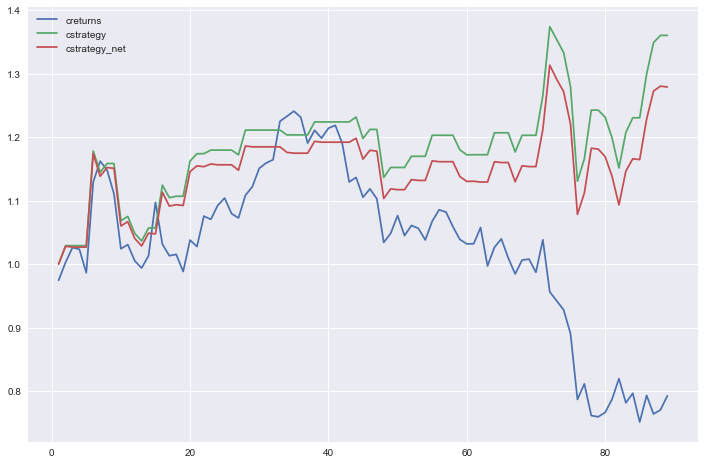

In [53]:
diff[["creturns", "cstrategy", "cstrategy_net"]].plot(figsize = (12 , 8))
plt.show()